In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib import pyplot as plt

In [2]:
import os
import function_training
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import json

import numpy as np
import tensorflow as tf

from dataLoader import AnyDataset
import function_training
from config import MLP_model,hyperparameters, args, CNN_model

numBands=100
bands_type="spin up"

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
# hyperparameters = {
#         "learning_rate": 0.00005,
#         "epochs": 100,
#         "batch_size": 10,
# }

In [4]:
# MLP_model = [
#     tf.keras.layers.Flatten(input_shape=(60, 100)),
#     # tf.keras.layers.Flatten(input_shape=(60, 400)),
#     tf.keras.layers.LeakyReLU(),

#     tf.keras.layers.Dense(10000, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(3125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),


#     tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),


#     tf.keras.layers.Dense(5),
#     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Softmax()
# ]
MLP_model = [
    tf.keras.layers.Flatten(input_shape=(60, 100)),
    # tf.keras.layers.Flatten(input_shape=(60, 400)),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Dense(10000, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(3125, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),


    tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),


    tf.keras.layers.Dense(5),
    tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Softmax()
]

In [5]:
# step 0. Check GPUs available:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))
# set device
device = tf.device('/GPU:0') if len(gpus) != 0 else tf.device('/CPU:0')

Num GPUs Available: 1
Metal device set to: Apple M1 Pro


In [6]:
# step 1. prepare dataset
def json2inputlabel(data_json, bands_type="spin up"):
    _bands_type = {"spin up": "spin_up_bands",
                   "spin down": "spin_down_bands",
                   "soc": "soc_bands"}
    data_input_np = np.array(data_json[_bands_type[bands_type]]) # 100 x 400
    # data_input_np = np.array(data_json[_bands_type[bands_type]]).flataten().T # 40000x1
    data_label_np = np.array([data_json["new_label"]])
    # data_label_np = np.array([data_json["layers_num"]])

    return data_input_np, data_label_np


#take data and set batch size here
train_dataset = AnyDataset("list/actual/train_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=True)
test_dataset = AnyDataset("list/actual/test_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=False)
train_loader = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs, train_dataset.data_labels)).shuffle(train_dataset.len).batch(hyperparameters['batch_size'])
test_loader = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(hyperparameters['batch_size'])


Loading test set: 100%|████████████████████████| 70/70 [00:00<00:00, 525.27it/s]


In [7]:
array = np.array(train_dataset.data_inputs)

In [8]:
np.unique(array)

array([-81.00049591, -81.00048828, -81.00048065, ...,  31.25984764,
        31.27856064,  31.41312599])

In [9]:
# x=810
# array[x:x+100]

In [10]:
# step 2. build model
model = tf.keras.Sequential(MLP_model)

# step 3. define loss
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# # step 4. Model compile
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=hyperparameters['learning_rate'],
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# step 5. select metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [11]:
# step 6. train & evaluate & save model
losses_train, accuracy_train, losses_test, accuracy_test, model = function_training.train_it(device, model, "./state_dicts/",
                                                                                      hyperparameters['epochs'],train_loader, test_loader, loss_fn, optimizer,
                                                                                      train_loss, train_accuracy, test_loss, test_accuracy,
                                                                                      eval_num_epochs=1, numClasss=args["load"]["numClasses"])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 6000)              0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10000)             60010000  
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 10000)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 3125)              31253125  
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 3125)              0

2022-04-07 11:28:05.269131: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1 | Loss:   2.2586841583251953 | Accuracy (%):   33.17230224609375
	Test Loss:  1.3031010627746582  |  Test Accuracy (%): 45.71428680419922
Epoch 2 | Loss:   1.574978232383728 | Accuracy (%):   42.834136962890625
	Test Loss:  1.179831624031067  |  Test Accuracy (%): 54.28571701049805
Epoch 3 | Loss:   1.3749189376831055 | Accuracy (%):   44.60547637939453
	Test Loss:  1.2446609735488892  |  Test Accuracy (%): 48.57143020629883
Epoch 4 | Loss:   1.3261734247207642 | Accuracy (%):   47.66505813598633
	Test Loss:  1.1143988370895386  |  Test Accuracy (%): 58.57142639160156
Epoch 5 | Loss:   1.2173155546188354 | Accuracy (%):   53.78422164916992
	Test Loss:  1.1317555904388428  |  Test Accuracy (%): 54.28571701049805
Epoch 6 | Loss:   1.1629667282104492 | Accuracy (%):   52.97906494140625
	Test Loss:  1.1440566778182983  |  Test Accuracy (%): 55.71428680419922
Epoch 7 | Loss:   1.1608128547668457 | Accuracy (%):   53.78422164916992
	Test Loss:  1.0145342350006104  |  Test Accuracy (%

Epoch 58 | Loss:   0.6732045412063599 | Accuracy (%):   75.36231994628906
	Test Loss:  0.8528505563735962  |  Test Accuracy (%): 75.71428680419922
Epoch 59 | Loss:   0.6691003441810608 | Accuracy (%):   73.75201416015625
	Test Loss:  0.8414874076843262  |  Test Accuracy (%): 70.0
Epoch 60 | Loss:   0.7161869406700134 | Accuracy (%):   72.78582763671875
	Test Loss:  0.9461895823478699  |  Test Accuracy (%): 68.5714340209961
Epoch 61 | Loss:   0.6430431008338928 | Accuracy (%):   76.48953247070312
	Test Loss:  1.366128921508789  |  Test Accuracy (%): 68.5714340209961
Epoch 62 | Loss:   0.6698840260505676 | Accuracy (%):   75.36231994628906
	Test Loss:  1.0108087062835693  |  Test Accuracy (%): 74.28571319580078
Epoch 63 | Loss:   0.6839599609375 | Accuracy (%):   75.0402603149414
	Test Loss:  0.804498553276062  |  Test Accuracy (%): 74.28571319580078
Epoch 64 | Loss:   0.6630845069885254 | Accuracy (%):   74.39613342285156
	Test Loss:  0.8157671689987183  |  Test Accuracy (%): 70.0
Epoch

Epoch 115 | Loss:   0.4547594487667084 | Accuracy (%):   83.73591613769531
	Test Loss:  0.8377152681350708  |  Test Accuracy (%): 71.42857360839844
Epoch 116 | Loss:   0.46060582995414734 | Accuracy (%):   82.93075561523438
	Test Loss:  1.2410542964935303  |  Test Accuracy (%): 74.28571319580078
Epoch 117 | Loss:   0.483887642621994 | Accuracy (%):   81.80354309082031
	Test Loss:  0.854949951171875  |  Test Accuracy (%): 71.42857360839844
Epoch 118 | Loss:   0.47188884019851685 | Accuracy (%):   82.28663635253906
	Test Loss:  1.0148462057113647  |  Test Accuracy (%): 72.85713958740234
Epoch 119 | Loss:   0.44982123374938965 | Accuracy (%):   84.54106140136719
	Test Loss:  0.8369466066360474  |  Test Accuracy (%): 77.14286041259766
Epoch 120 | Loss:   0.44419166445732117 | Accuracy (%):   83.89694213867188
	Test Loss:  1.1213372945785522  |  Test Accuracy (%): 75.71428680419922
Epoch 121 | Loss:   0.4467839300632477 | Accuracy (%):   84.3800277709961
	Test Loss:  0.7601640224456787  |  

Epoch 171 | Loss:   0.323668897151947 | Accuracy (%):   87.76167297363281
	Test Loss:  1.3668408393859863  |  Test Accuracy (%): 77.14286041259766
Epoch 172 | Loss:   0.3212050795555115 | Accuracy (%):   88.083740234375
	Test Loss:  0.9455307722091675  |  Test Accuracy (%): 78.57142639160156
Epoch 173 | Loss:   0.3488248288631439 | Accuracy (%):   87.9227066040039
	Test Loss:  1.326897144317627  |  Test Accuracy (%): 74.28571319580078
Epoch 174 | Loss:   0.297420471906662 | Accuracy (%):   89.37197875976562
	Test Loss:  1.4944045543670654  |  Test Accuracy (%): 78.57142639160156
Epoch 175 | Loss:   0.2984233796596527 | Accuracy (%):   89.85507202148438
	Test Loss:  1.1923948526382446  |  Test Accuracy (%): 80.0
Epoch 176 | Loss:   0.33894082903862 | Accuracy (%):   87.1175537109375
	Test Loss:  2.029057741165161  |  Test Accuracy (%): 68.5714340209961
Epoch 177 | Loss:   0.3896706998348236 | Accuracy (%):   84.54106140136719
	Test Loss:  1.149148941040039  |  Test Accuracy (%): 75.7142

Epoch 228 | Loss:   0.24364042282104492 | Accuracy (%):   91.78743743896484
	Test Loss:  1.0231589078903198  |  Test Accuracy (%): 75.71428680419922
Epoch 229 | Loss:   0.21694675087928772 | Accuracy (%):   93.2367172241211
	Test Loss:  1.1522473096847534  |  Test Accuracy (%): 78.57142639160156
Epoch 230 | Loss:   0.23098993301391602 | Accuracy (%):   91.78743743896484
	Test Loss:  1.5555593967437744  |  Test Accuracy (%): 77.14286041259766
Epoch 231 | Loss:   0.2190481424331665 | Accuracy (%):   91.78743743896484
	Test Loss:  1.7854158878326416  |  Test Accuracy (%): 78.57142639160156
Epoch 232 | Loss:   0.23347501456737518 | Accuracy (%):   92.10950469970703
	Test Loss:  1.3692330121994019  |  Test Accuracy (%): 77.14286041259766
Epoch 233 | Loss:   0.2236812859773636 | Accuracy (%):   92.43156433105469
	Test Loss:  1.5278334617614746  |  Test Accuracy (%): 75.71428680419922
Epoch 234 | Loss:   0.29067397117614746 | Accuracy (%):   89.85507202148438
	Test Loss:  1.083589792251587  |

Epoch 284 | Loss:   0.20543241500854492 | Accuracy (%):   93.07568359375
	Test Loss:  1.2142794132232666  |  Test Accuracy (%): 78.57142639160156
Epoch 285 | Loss:   0.17601223289966583 | Accuracy (%):   94.68598937988281
	Test Loss:  1.9290802478790283  |  Test Accuracy (%): 77.14286041259766
Epoch 286 | Loss:   0.14684133231639862 | Accuracy (%):   95.49114990234375
	Test Loss:  3.146127223968506  |  Test Accuracy (%): 75.71428680419922
Epoch 287 | Loss:   0.1721852719783783 | Accuracy (%):   94.04186248779297
	Test Loss:  1.615609884262085  |  Test Accuracy (%): 80.0
Epoch 288 | Loss:   0.19275204837322235 | Accuracy (%):   93.07568359375
	Test Loss:  2.4063048362731934  |  Test Accuracy (%): 78.57142639160156
Epoch 289 | Loss:   0.1987934559583664 | Accuracy (%):   92.75362396240234
	Test Loss:  1.4161324501037598  |  Test Accuracy (%): 75.71428680419922
Epoch 290 | Loss:   0.22937622666358948 | Accuracy (%):   92.27053833007812
	Test Loss:  1.6009299755096436  |  Test Accuracy (%)

2022-04-07 11:32:05.356794: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./state_dicts/assets


In [12]:
# for test_x, test_labels in test_loader:
#     print (f"model {model(test_x,training=False)}, actual {test_labels}")

In [13]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    
    figure = plt.figure(figsize=(8, 8), dpi=400)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
#     plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
#     plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)


    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Prediction')
#     return figure

In [14]:
test_loader2 = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(train_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in test_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])
    predict = np.argmax(model.predict(element), axis=-1)
    label = np.array(labels).flatten()
#     print (f"model {model.predict_classes(element)}, actual {labels}")
#     model.predict_classes(element)
    break


In [15]:
cm = np.array(tf.math.confusion_matrix(labels=label, predictions=predict))

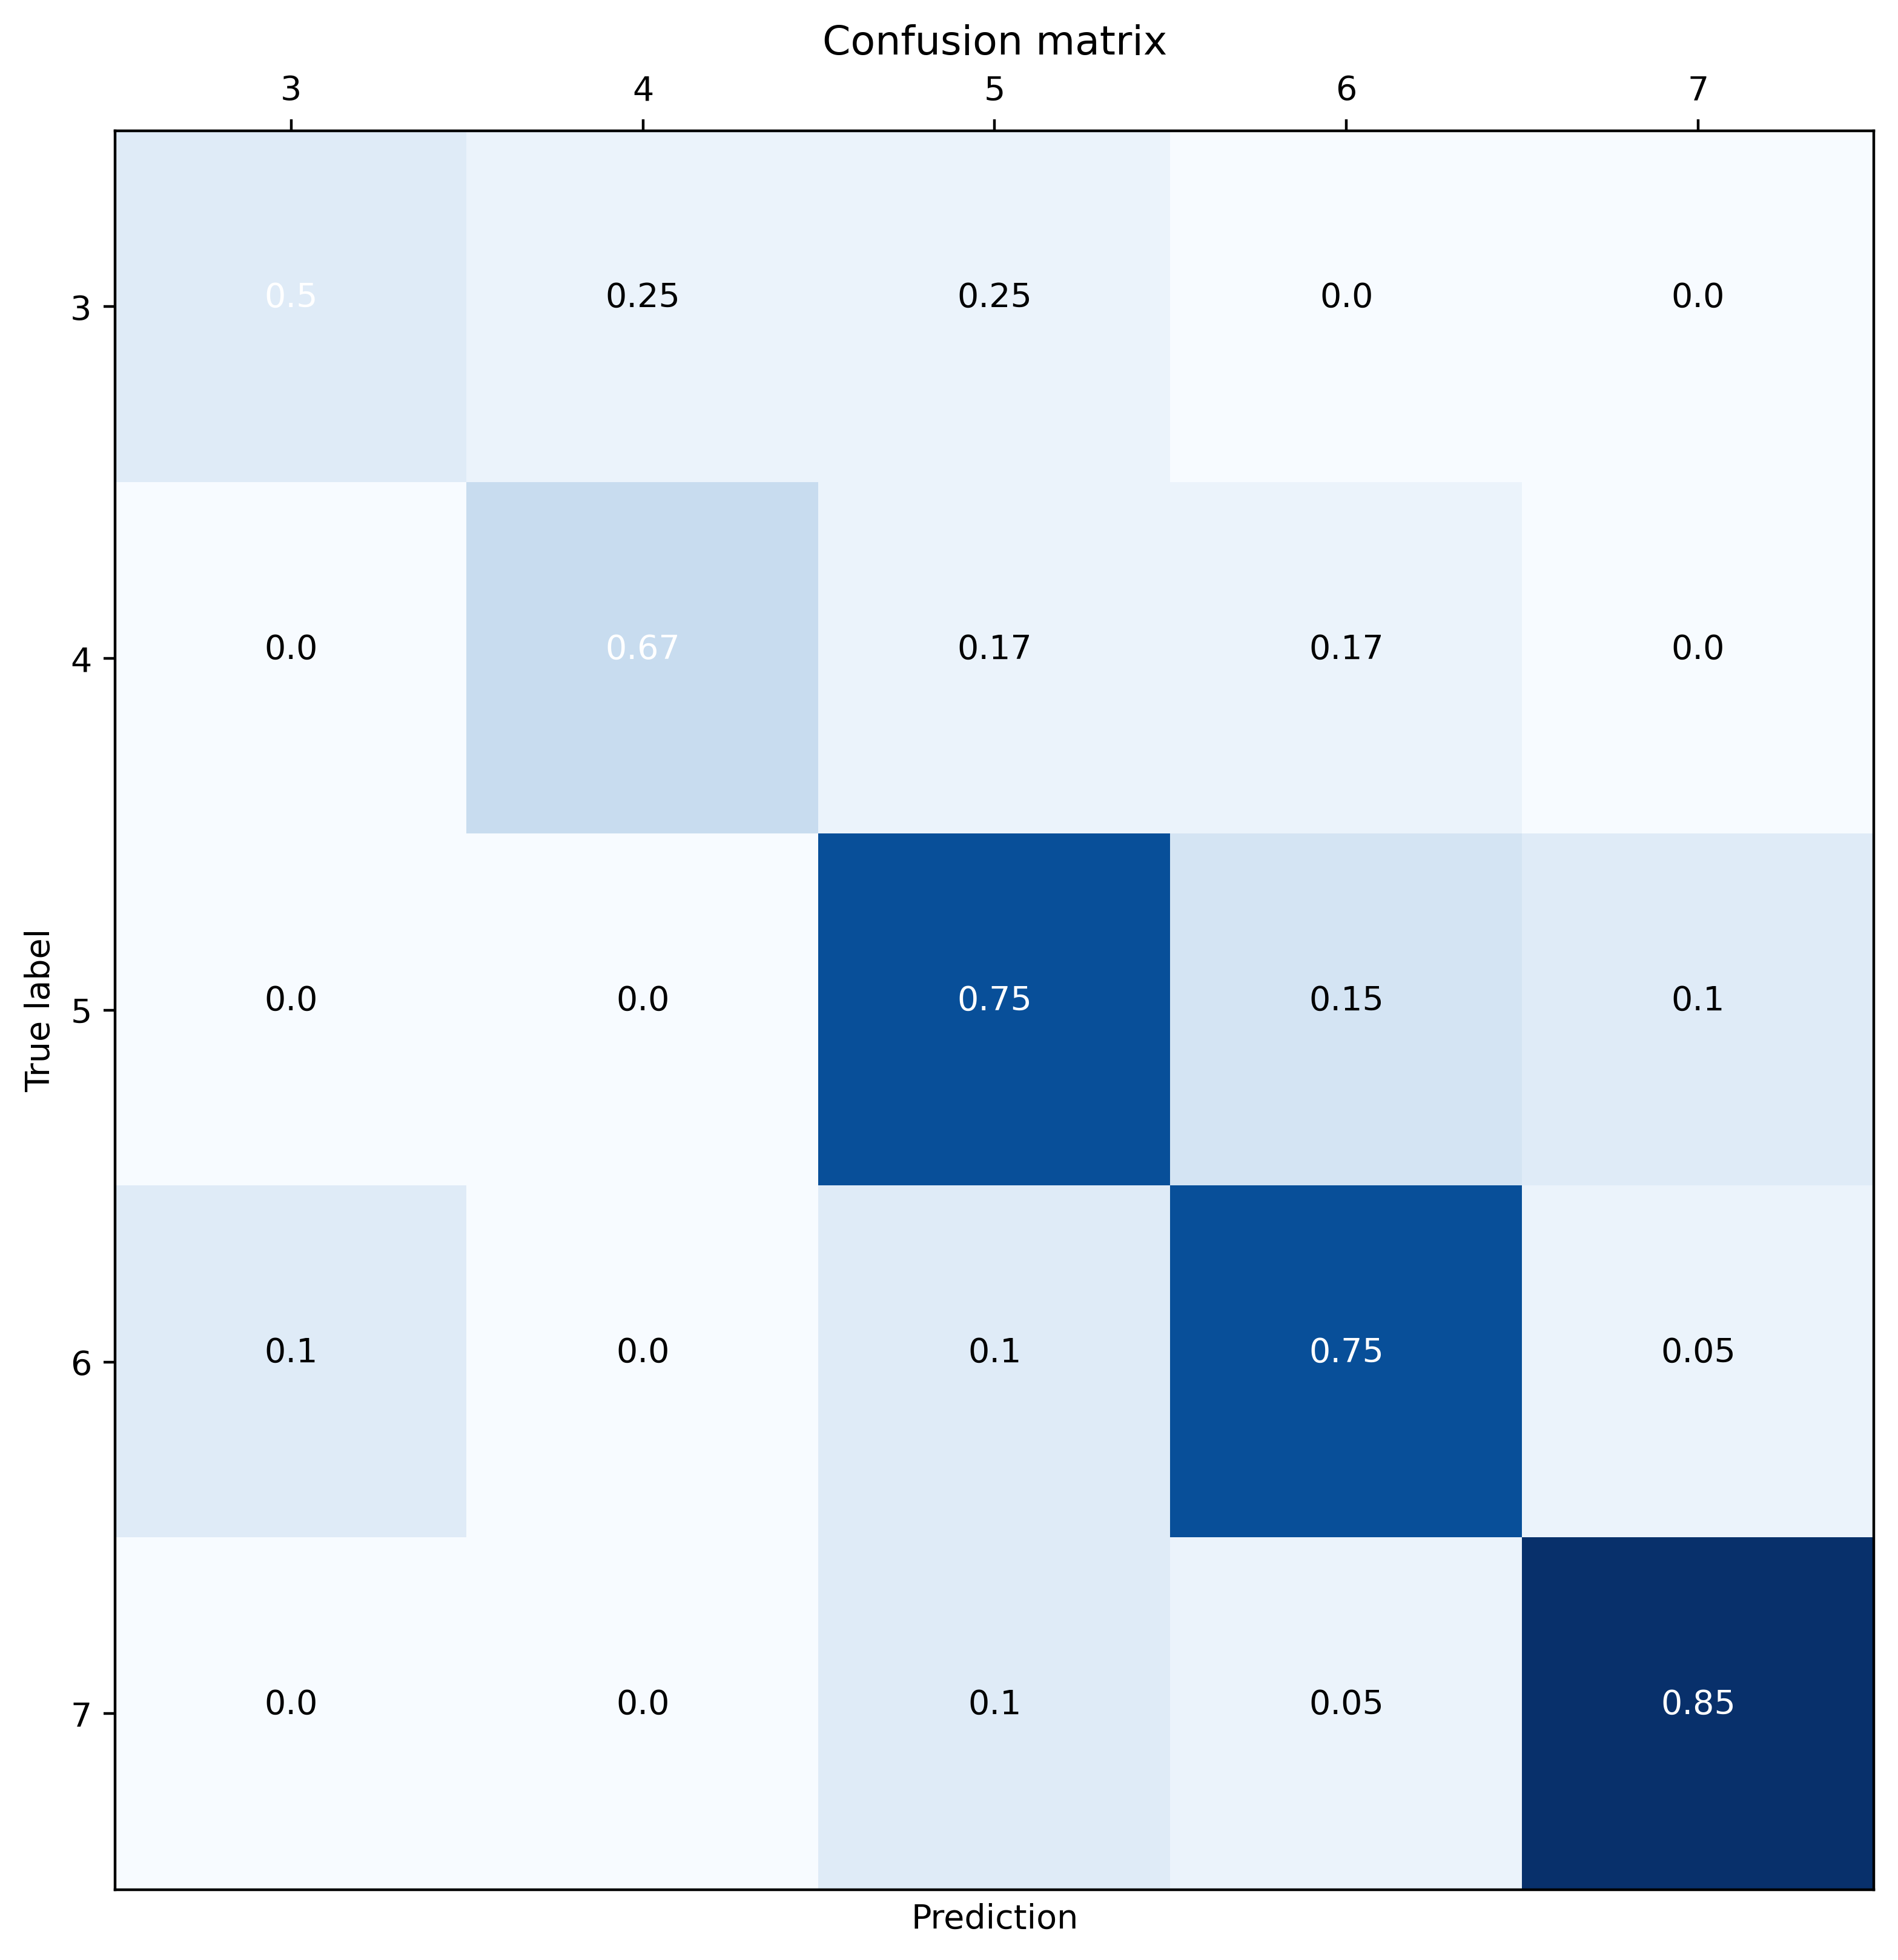

In [16]:
plot_confusion_matrix(cm, [3, 4, 5, 6, 7])